# Image Similarity Metrics

In [ ]:
!pip install ISR
!pip install lpips
!pip install pytorch-msssim
!wget https://i.imgur.com/FUEI6q6.png -O hr.png
!wget https://i.imgur.com/KxSCUcg.png -O lr.png

from PIL import Image
import numpy as np
import torch
import cv2
from ISR.models import RRDN
from pytorch_msssim import ssim
import lpips
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor, Normalize

def plot_images(images, titles):
    fig, axis = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        axis[i].set_title(title)
        axis[i].imshow(image)
        axis[i].axes.xaxis.set_visible(False)
        axis[i].axes.yaxis.set_visible(False)

    plt.axis('off')
    fig.show()

rrdn = RRDN(weights='gans')
to_tensor = ToTensor()

lpips_alex = lpips.LPIPS(net='alex')
normalize = Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

Let's consider the following task. We want to map this:

<img src="https://i.imgur.com/KxSCUcg.png"/>

Into this:

<img src="https://i.imgur.com/FUEI6q6.png"/>

In [ ]:
img_hr = Image.open('hr.png')
img_lr = Image.open('lr.png')

Simple solution: let's use computer vision filters!

In [ ]:
bilinear = img_lr.resize(size=img_hr.size, resample=Image.BILINEAR)
bicubic = img_lr.resize(size=img_hr.size, resample=Image.BICUBIC)
lanczos = img_lr.resize(size=img_hr.size, resample=Image.LANCZOS)

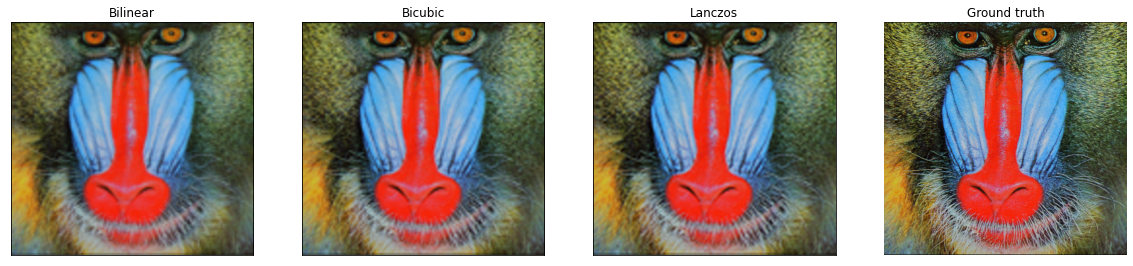

In [ ]:
plot_images([bilinear, bicubic, lanczos, img_hr], ['Bilinear', 'Bicubic', 'Lanczos', 'Ground truth'])

Is there a way to evaluate these differences? Yes! Actually, multiple ways.

## PSNR (Peak Signal-to-Noise Ratio)

$$
    \text{PSNR} = 10 \cdot \log_{10} \Bigg( \frac{\text{MAX}^2}{\text{MSE}} \Bigg)
$$

$\text{MAX}$ is just a normalization constant, for 8 bit image it is 255.

In [ ]:
psnr_bilinear = cv2.PSNR(np.asarray(bilinear), np.asarray(img_hr), 255)
psnr_bicubic = cv2.PSNR(np.asarray(bicubic), np.asarray(img_hr), 255)
psnr_lanczos = cv2.PSNR(np.asarray(lanczos), np.asarray(img_hr), 255)
psnr_gt = cv2.PSNR(np.asarray(img_hr), np.asarray(img_hr), 255)

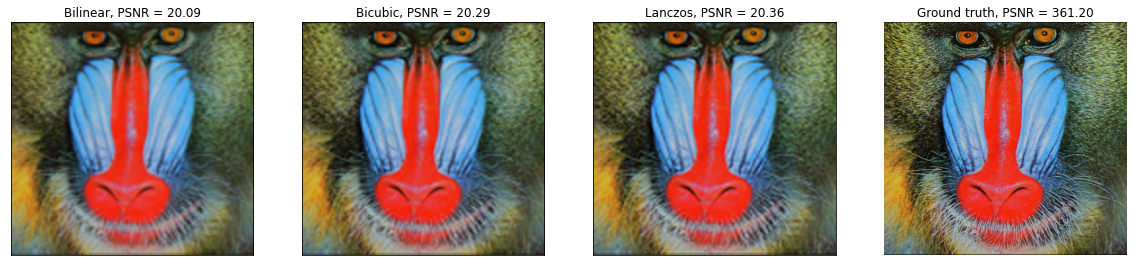

In [ ]:
plot_images([bilinear, bicubic, lanczos, img_hr], [f'Bilinear, PSNR = {psnr_bilinear:.2f}', 
                                                   f'Bicubic, PSNR = {psnr_bicubic:.2f}',
                                                   f'Lanczos, PSNR = {psnr_lanczos:.2f}',
                                                   f'Ground truth, PSNR = {psnr_gt:.2f}'])

Let's push the limits of PSNR and have a small detour.

Which of these images is more similar to the ground truth?

In [ ]:
img = np.asarray(img_hr) / 255.
noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1
img_noisy = (img + noise).clip(0, 1)
img_plus_constant = (img + abs(noise)).clip(0, 1)
plot_images([img_noisy, img_plus_constant, img_hr], ['Noisy', 'Plus constant', 'Ground truth'])

In [ ]:
psnr_noisy = cv2.PSNR(img_noisy, np.asarray(img_hr) / 255., 1.)
psnr_plus_constant = cv2.PSNR(img_plus_constant, np.asarray(img_hr) / 255., 1.)

plot_images([img_noisy, img_plus_constant, img_hr], [f'Noisy PSNR = {psnr_noisy:.2f}', f'Plus constant PSNR = {psnr_plus_constant:.2f}', 'Ground truth'])

PSNR treats pixels independently, and this is not how our visual perception works!

## SSIM (Structural Similarity Index)

$$
    \text{SSIM}(x, y) = \frac{ (2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2) }{ (\mu_x^2 + \mu_y^2 + c_1) (\sigma_x^2 + \sigma_y^2 + c_2) },
$$

where $c_1$ and $c_2$ prevent division by zero.

In [ ]:
ssim_noisy = ssim(torch.from_numpy(img_noisy)[None], torch.from_numpy(np.asarray(img_hr) / 255.)[None], 1.).item()
ssim_plus_constant = ssim(torch.from_numpy(img_plus_constant)[None], torch.from_numpy(np.asarray(img_hr) / 255.)[None], 1.).item()

/usr/local/lib/python3.7/dist-packages/pytorch_msssim/ssim.py:51: UserWarning: Skipping Gaussian Smoothing at dimension 2+1 for input: torch.Size([1, 480, 500, 3]) and win size: 11
  f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"


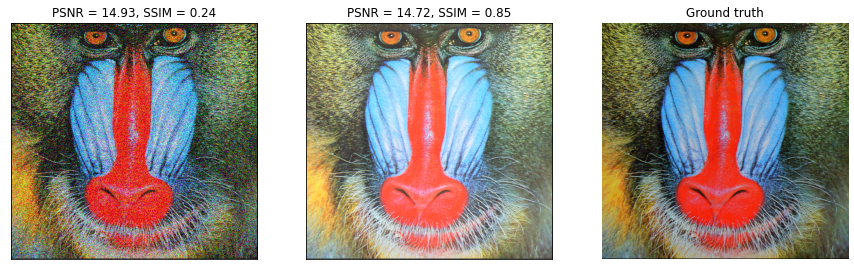

In [ ]:
plot_images([img_noisy, img_plus_constant, img_hr], 
            [f'PSNR = {psnr_noisy:.2f}, SSIM = {ssim_noisy:.2f}', 
             f'PSNR = {psnr_plus_constant:.2f}, SSIM = {ssim_plus_constant:.2f}', 
             'Ground truth'])

## Comparison with Deep Generative Models

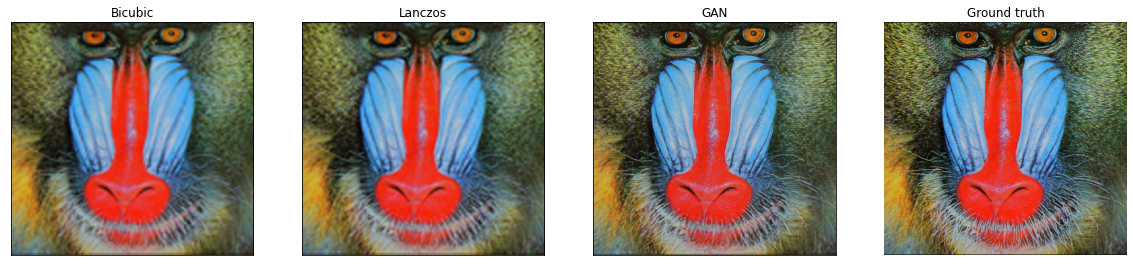

In [ ]:
img_sr = Image.fromarray(rrdn.predict(np.asarray(img_lr)))

plot_images([bicubic, lanczos, img_sr, img_hr], 
            ['Bicubic', 
             'Lanczos',
             'GAN',
             'Ground truth'])

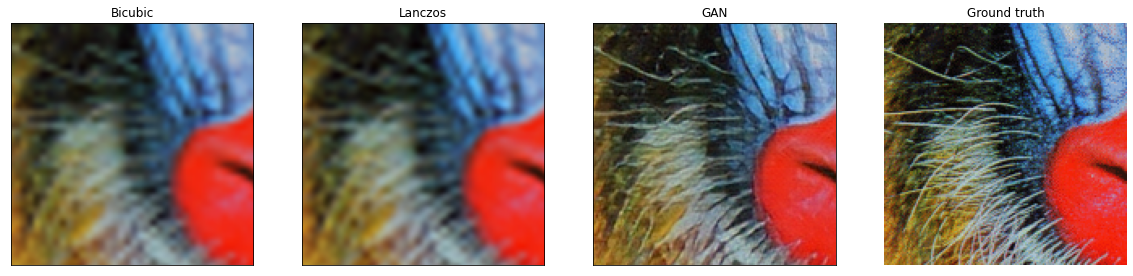

In [ ]:
box = (50, 250, 200, 400)

plot_images([bicubic.crop(box), lanczos.crop(box), img_sr.crop(box), img_hr.crop(box)], 
            ['Bicubic',
             'Lanczos',
             'GAN',
             'Ground truth'])

In [ ]:
psnr_gan = cv2.PSNR(np.asarray(img_sr), np.asarray(img_hr), 255)

ssim_bicubic = ssim(to_tensor(bicubic)[None], to_tensor(img_hr)[None], 1.).item()
ssim_lanczos = ssim(to_tensor(lanczos)[None], to_tensor(img_hr)[None], 1.).item()
ssim_gan = ssim(to_tensor(img_sr)[None], to_tensor(img_hr)[None], 1.).item()

plot_images([bicubic, lanczos, img_sr, img_hr], 
            [f'Bicubic, PSNR = {psnr_bicubic:.2f}, SSIM = {ssim_bicubic:.2f}', 
             f'Lanczos, PSNR = {psnr_lanczos:.2f}, SSIM = {ssim_lanczos:.2f}',
             f'GAN, PSNR = {psnr_gan:.2f}, SSIM = {ssim_gan:.2f}',
             'Ground truth'])

## LPIPS (Learned Perceptual Image Patch Similarity)

<img src="https://i.imgur.com/vXkvRml.jpg"/>

How it works:

<img src="https://richzhang.github.io/PerceptualSimilarity/index_files/network.jpg"/>

The objective is to match ($1 -$) similarity score of images provided by human respondents.

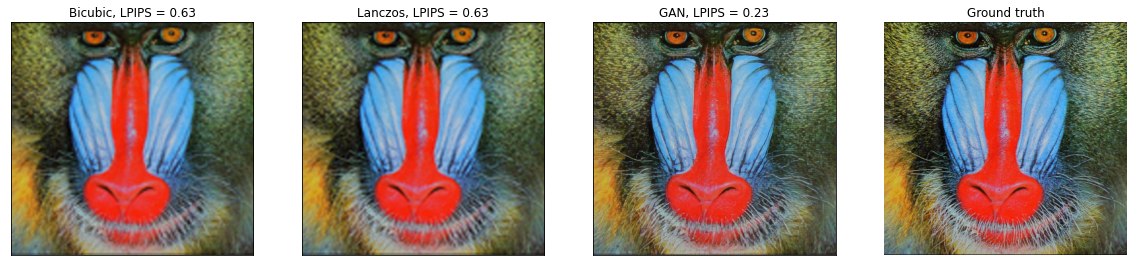

In [ ]:
lpips_bicubic = lpips_alex(normalize(to_tensor(bicubic)[None]), normalize(to_tensor(img_hr)[None])).item()
lpips_lanczos = lpips_alex(normalize(to_tensor(lanczos)[None]), normalize(to_tensor(img_hr)[None])).item()
lpips_gan = lpips_alex(normalize(to_tensor(img_sr)[None]), normalize(to_tensor(img_hr)[None])).item()

plot_images([bicubic, lanczos, img_sr, img_hr], 
            [f'Bicubic, LPIPS = {lpips_bicubic:.2f}', 
             f'Lanczos, LPIPS = {lpips_lanczos:.2f}',
             f'GAN, LPIPS = {lpips_gan:.2f}',
             'Ground truth'])